#### Sources of causal gene to disease associations

Heuristic for determining if a gene to disease association is causal:

OMIM
- Gene to disease associations where the molecular basis is known, excluding
  - abnormal laboratory test values and non-diseases
  - susceptibility to complex and common disease
  - provisional gene to phenotype associations

Orphanet
- Disease-causing germline mutation(s) in
- Disease-causing somatic mutation(s) in
- Disease-causing germline mutation(s) (gain of function) in
- Disease-causing germline mutation(s) (loss of function) in

ClinVar
- Variant is pathogenic for condition AND the gene to disease association is present in the gene to condition file provided by ClinVar, which includes manual curation by NCBI staff and data from OMIM and GeneReviews


This notebook uses the Monarch API to generate a break down of counts of gene-disease pairs per source


In [1]:
import urllib.request
import re
import requests


# TODO update to production API before submission
monarch_api = "https://api-dev.monarchinitiative.org/api/"

# Protein coding genes from HGNC
hgnc = 'ftp://ftp.ebi.ac.uk/pub/databases/genenames/new/tsv/locus_types/gene_with_protein_product.txt'

protein_coding_genes = set()

hgnc_resp = urllib.request.urlopen(hgnc).read()
for line in hgnc_resp.decode('utf-8').splitlines():
    protein_coding_genes.add(re.split(r'\t', line)[0])
        
print("Protein coding genes: {}".format(len(protein_coding_genes)))

Protein coding genes: 19322


In [2]:
def get_gene_disease_associations(causality='causal'):
    """
    Fetches gene to disease associations from the monarch API
    
    :param causality: 'causal', 'non-causal', 'both'
    
    Returns a list of 3-tuples of (gene_id, disease_id, [evidence])
    """
    results = []
        
    disease_gene = monarch_api + "bioentity/disease/MONDO:0000001/genes"
    params = {
        'rows': 500,
        'start': 0,
        'unselect_evidence': True,
        'association_type': causality
    }
    
    resultCount = params['rows']
    
    while params['start'] < resultCount:
        biolink_request = requests.get(disease_gene, params=params)
        response = biolink_request.json()
        resultCount = response['numFound']
        params['start'] += params['rows']
        
        for assoc in response['associations']:
            gene_id = assoc['object']['id']
            disease_id = assoc['subject']['id']
            evidence = assoc['provided_by']
            results.append((gene_id, disease_id, evidence))
    
    return results

gene_disease_assocs = get_gene_disease_associations('causal')

gene_disease_assocs[0]

('HGNC:27232',
 'MONDO:0015993',
 ['https://data.monarchinitiative.org/ttl/orphanet.ttl'])

In [14]:
# Process results

unique_genes, omim_only, orphanet_only = set(), set(), set()
clinvar_only, omim_orphanet, omim_clinvar = set(), set(), set()
omim_clinvar, orphanet_clinvar, all_evidence = set(), set(), set()
non_redun_orphanet = set()

src_to_num = {
    "https://data.monarchinitiative.org/ttl/omim.ttl": 1,
    "https://data.monarchinitiative.org/ttl/orphanet.ttl": 3,
    "https://data.monarchinitiative.org/ttl/clinvar.nt": 5
}

for gene_id, disease_id, evidence in gene_disease_assocs:
    evidence_num = sum([src_to_num[ev] for ev in evidence if ev in src_to_num])
    
    if gene_id not in protein_coding_genes:
        continue
        
    if evidence_num == 0:
        continue
    
    unique_genes.add(gene_id)

    if evidence_num == 1:
        omim_only.add((gene_id, disease_id))

    elif evidence_num == 3:
        orphanet_only.add((gene_id, disease_id))

    elif evidence_num == 5:
        clinvar_only.add((gene_id, disease_id))

    elif evidence_num == 4:
        omim_orphanet.add((gene_id, disease_id))

    elif evidence_num == 6:
        omim_clinvar.add((gene_id, disease_id))

    elif evidence_num == 8:
        orphanet_clinvar.add((gene_id, disease_id))

    elif evidence_num == 9:
        all_evidence.add((gene_id, disease_id))
        

# Determine cases where an Orphanet disease subsumes an OMIM disease
# identifier in MONDO and remove from the orphanet only list
for gene_id, disease_id in orphanet_only:
    is_redundant = False
    # Get all subclasses of mondo ID
    subclass_query = monarch_api + "graph/edges/from/" + disease_id
    params = {
        'depth': 100,
        'direction': 'INCOMING',
        'relationship_type': 'subClassOf'
    }
    
    biolink_request = requests.get(subclass_query, params=params)
    response = biolink_request.json()
    
    for node in response['nodes']:
        if (gene_id, node['id']) in omim_clinvar:
            is_redundant = True
            break
        elif (gene_id, node['id']) in omim_only:
            is_redundant = True
            break
                
    if not is_redundant:
        non_redun_orphanet.add((gene_id, disease_id))

print("Number of human genes with a causal g2p association: {}".format(len(unique_genes)))
print("OMIM Only Evidence: {}".format(len(omim_only)))
print("Orphanet Only Evidence: {}".format(len(non_redun_orphanet)))
print("ClinVar Only Evidence: {}".format(len(clinvar_only)))
print("OMIM and Orphanet Evidence: {}".format(len(omim_orphanet)))
print("OMIM and ClinVar Evidence: {}" .format(len(omim_clinvar)))
print("Orphanet and ClinVar Evidence: {}".format(len(orphanet_clinvar)))
print("OMIM, Orphanet, ClinVar Evidence: {}".format(len(all_evidence)))

Number of human genes with a causal g2p association: 3799
OMIM Only Evidence: 168
Orphanet Only Evidence: 1979
ClinVar Only Evidence: 0
OMIM and Orphanet Evidence: 831
OMIM and ClinVar Evidence: 2372
Orphanet and ClinVar Evidence: 82
OMIM, Orphanet, ClinVar Evidence: 2323


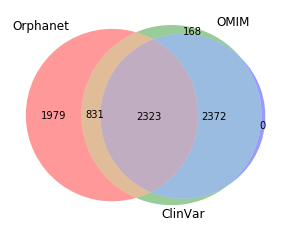

In [17]:
import matplotlib.pyplot as plt
from matplotlib_venn import venn3

venn3(subsets = (
    len(non_redun_orphanet),
    len(omim_only),
    len(omim_orphanet),
    len(clinvar_only),
    len(orphanet_clinvar),
    len(omim_clinvar),
    # len(orphanet_clinvar),
    len(all_evidence)
), set_labels = ('Orphanet', 'OMIM', 'ClinVar'))

plt.savefig('disease-venn.png')
plt.show()